# why is this interface so weird?

it's jupyter notebook!!

some are text blocks like this one and some are code blocks like the one below

In [1]:
for i in range(5):
    print(i) 

0
1
2
3
4


also we can run bash commands like this

In [2]:
!ls

LICENSE    main.ipynb


# what we doing today?

[relevant xkcd comic](https://xkcd.com/1425/) from 2015 (ofcourse!)

input: some random image with either a bird or a dog in it

output: is the image of a bird or a dog

note: i highly recommend instead of "bird" and "dog" think of your own categories or maybe even more than just 2 categories like differnt dinosaur types or different foods and change the code accordingly

# how?

only 2 steps:

1. download images of all categories
2. train our model

# setup

we'll be using the fastai library for neural network stuff and duckduckgo for searching images

In [3]:
!pip install -Uqq fastai duckduckgo_search # -Uqq means we use the most recent version and quitely

let's import

In [4]:
from duckduckgo_search import ddg_images
from fastcore.all import *
from fastdownload import download_url
from fastai.vision.all import *

# step 1: download images of all categories

search [duckduckgo](https://duckduckgo.com/) for images of bird and get the url

In [5]:
def search_images(term, max_images=100):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

In [6]:
urls = search_images('bird photos', max_images=1)
urls[0]

Searching for 'bird photos'


/Users/daspartho/anaconda3/lib/python3.10/site-packages/duckduckgo_search/compat.py:60: UserWarning: ddg_images is deprecated. Use DDGS().images() generator
  warnings.warn("ddg_images is deprecated. Use DDGS().images() generator")
/Users/daspartho/anaconda3/lib/python3.10/site-packages/duckduckgo_search/compat.py:64: UserWarning: parameter page is deprecated
  warnings.warn("parameter page is deprecated")
/Users/daspartho/anaconda3/lib/python3.10/site-packages/duckduckgo_search/compat.py:66: UserWarning: parameter max_results is deprecated
  warnings.warn("parameter max_results is deprecated")


'https://2.bp.blogspot.com/-g9STQqFQ9Ik/UScse2IifqI/AAAAAAAAA08/mh1immEtVZo/s1600/bluebird.jpg'

next we download the image from url and take a look at it

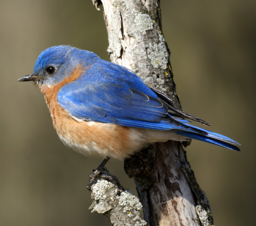

In [7]:
dest = 'bird.jpg'
download_url(urls[0], dest, show_progress=False)

im = Image.open(dest)
im.to_thumb(256,256)

let's do the same for dogs

Searching for 'dog photos'


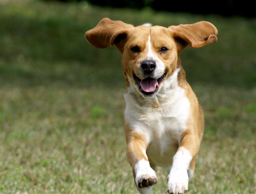

In [8]:
download_url(search_images('dog photos', max_images=1)[0], 'dog.jpg', show_progress=False)
Image.open('dog.jpg').to_thumb(256,256)

our searches seem to be giving reasonable results!

so let's grab a few examples of each category, and save each group of photos to a different folder

In [9]:
searches = "bird", "dog"
path = Path('bird_or_dog')

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'bird photo'
Searching for 'dog photo'


some photos might not download correctly which could cause our model training to fail so we'll remove them

In [10]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

1

# step 2: train our model

to train our model we'll need to structure our data a certain way using `DataBlock` so that we can get it into the model

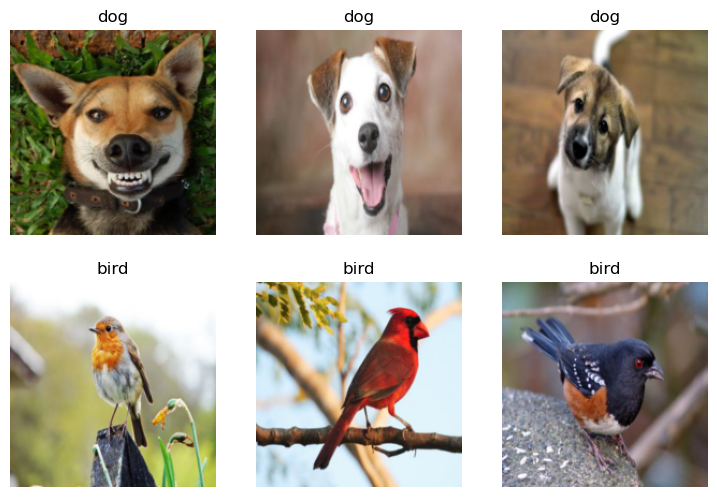

In [11]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), # input is images and output are categories
    get_items=get_image_files, # to find all the inputs to our model, we'll run the get_image_files function (which returns a list of all image files in a path)
    splitter=RandomSplitter(valid_pct=0.2, seed=42), # split data with 20% for validation set
    get_y=parent_label, # the labels is the name of the parent folder of each file (i.e. the name of the folder they're in, which will be bird or dog)
    item_tfms=[Resize(192, method='squish')] # resize each image to 192x192 pixels by "squishing" it 
).dataloaders(path, bs=32) # splitting the data into batches of 32 images

dls.show_batch(max_n=6)

now we're ready to train our model

we'll finetune `resnet18` model on our dataset

you can repace `resnet18` with:
- `resnet34`
- `resnet50`
- `resnet101`
- `resnet152`

larger number means larger model which will be more capable but will take more time to train (or may not train at all on cpu)

In [12]:
learner = vision_learner(dls, resnet18, metrics=error_rate)
learner.fine_tune(3)

/Users/daspartho/anaconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/daspartho/anaconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,time
0,0.959475,0.206350,0.060606,00:01


epoch,train_loss,valid_loss,error_rate,time
0,0.092517,0.013357,0.000000,00:01
1,0.053392,0.000406,0.000000,00:01
2,0.035046,0.000728,0.000000,00:01


# let's use our model

let's download an image from internet for trying the model

Searching for 'golden retriever'


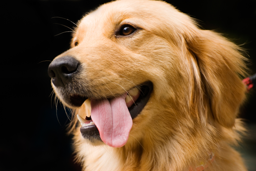

In [13]:
term='golden retriever' # change the search term
download_url(search_images(term, max_images=1)[0], 'test.jpg', show_progress=False)
Image.open('test.jpg').to_thumb(256,256)
     

In [14]:
pred,n,prob = learner.predict(PILImage.create('test.jpg'))
print(f"This is a {pred}!")
perc = prob[n]*100
print(f"I'm {perc:.02f}% confident.")

This is a dog!
I'm 100.00% confident.


Good job, `resnet18` :)

# export the model

In [15]:
learner.export('model.pkl')

# optional: deploy it

In [16]:
!pip install -Uqq gradio

In [17]:
import gradio as gr

learn_inf = load_learner('model.pkl')
categories = learn_inf.dls.vocab

def classify_image(img):
    pred,pred_idx,probs = learn_inf.predict(img)
    return dict(zip(categories, map(float, probs))) 

iface = gr.Interface(
    fn=classify_image, 
    inputs=gr.Image(shape=(192,192)), 
    outputs=gr.outputs.Label(),
    )
iface.launch()

/Users/daspartho/anaconda3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/var/folders/9z/70yv474j197cch6_nqfmlfy80000gn/T/ipykernel_29956/1999656360.py:13: GradioDeprecationWarning: Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components
  outputs=gr.outputs.Label(),
/var/folders/9z/70yv474j197cch6_nqfmlfy80000gn/T/ipykernel_29956/1999656360.py:13: GradioUnusedKwargWarning: You have unused kwarg parameters in Label, please remove them: {'type': 'auto'}
  outputs=gr.outputs.Label(),


Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


# where to learn more?

- [fastai course](https://course.fast.ai/) (i ripped-off it's first lesson)
- [3blue1brown's series on neural networks](https://www.youtube.com/playlist?list=PLZHQObOWTQDNU6R1_67000Dx_ZCJB-3pi)